In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque, OrderedDict
import random
from copy import deepcopy

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)

        # Initialize weights
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x, thompson_probs=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        action_probs = F.softmax(self.fc5(x), dim=-1) + 1e-8

        # Incorporate Thompson sampling probabilities
        if thompson_probs is not None:
            action_probs = action_probs * thompson_probs
            action_probs = action_probs / (action_probs.sum() + 1e-10)

        return action_probs

class MetaPolicy:
    def __init__(self, policy):
        self.policy = policy
        self.params = OrderedDict(policy.named_parameters())

    def update_params(self, loss, step_size=0.1, first_order=False):
        grads = torch.autograd.grad(loss, self.params.values(),
                                    create_graph=not first_order)

        updated_params = OrderedDict()
        for (name, param), grad in zip(self.params.items(), grads):
            updated_params[name] = param - step_size * grad.clamp(-5, 5)  # Gradient clipping
        return updated_params

    def set_params(self, params):
        for name, param in self.policy.named_parameters():
            param.data = params[name].data.clone()

class ThompsonMAML:
    def __init__(self, state_dim, action_dim, hidden_dim=64,
                 inner_lr=0.001, meta_lr=0.01,
                 num_tasks=50, k_shots=20,
                 memory_size=1000, batch_size=32,
                 gamma=0.99, epsilon=0.1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy = PolicyNetwork(state_dim, hidden_dim, action_dim).to(self.device)
        self.meta_policy = MetaPolicy(self.policy)
        self.meta_optimizer = optim.Adam(self.policy.parameters(), lr=meta_lr)
        self.meta_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.meta_optimizer, 1000, meta_lr/100)

        self.inner_lr = inner_lr

        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        self.gamma = gamma
        self.epsilon = epsilon
        self.num_tasks = num_tasks
        self.k_shots = k_shots
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.epsilon = 0.5
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99

        # Reward normalization using moving averages
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_ema_alpha = 0.1  # Smoothing factor for exponential moving average

        self.alpha = np.ones(action_dim) * 1.0
        self.beta = np.ones(action_dim) * 1.0

        # Add reward scaling
        self.reward_scale = 0.1

        # Episode statistics
        self.current_episode_length = 0
        self.max_episode_length = 500  # Typical max length for CartPole

    def select_action(self, state, thompson=True):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

            if thompson:
                # Sample Thompson probabilities
                thompson_probs = np.array([np.random.beta(self.alpha[i], self.beta[i])
                                           for i in range(self.action_dim)])
                thompson_probs = torch.FloatTensor(thompson_probs).to(self.device)

                # Get policy probabilities incorporating Thompson sampling
                probs = self.policy(state, thompson_probs).cpu().numpy()[0]
            else:
                probs = self.policy(state).cpu().numpy()[0]

            if random.random() < self.epsilon:
                return random.randrange(self.action_dim)
            return np.argmax(probs)

    def normalize_reward(self, reward):
        self.reward_mean = (1 - self.reward_ema_alpha) * self.reward_mean + self.reward_ema_alpha * reward
        self.reward_std = (1 - self.reward_ema_alpha) * self.reward_std + self.reward_ema_alpha * abs(reward - self.reward_mean)
        return (reward - self.reward_mean) / (self.reward_std + 1e-8)

    def store_transition(self, state, action, reward, next_state, done):
        # Normalize rewards before storing
        normalized_reward = self.normalize_reward(reward)
        self.memory.append((state, action, normalized_reward, next_state, done))

        self.current_episode_length += 1

        # Balanced Thompson updates
        if done:
            success = self.current_episode_length >= self.max_episode_length
            update_value = self.reward_scale * (1.0 if success else 0.0)

            self.alpha[action] += update_value
            self.beta[action] += (1.0 - update_value)

            self.current_episode_length = 0
        else:
            # Smaller intermediate updates
            step_reward = max(0, reward * self.reward_scale * 0.1)
            self.alpha[action] += step_reward
            self.beta[action] += (1.0 - step_reward) * 0.1

    def prepare_batch(self, batch):
        states = torch.FloatTensor([t[0] for t in batch]).to(self.device)
        actions = torch.LongTensor([t[1] for t in batch]).to(self.device)
        rewards = torch.FloatTensor([t[2] for t in batch]).to(self.device)
        next_states = torch.FloatTensor([t[3] for t in batch]).to(self.device)
        dones = torch.FloatTensor([t[4] for t in batch]).to(self.device)
        return states, actions, rewards, next_states, dones

    def compute_loss(self, states, actions, rewards, policy=None):
        if policy is None:
            policy = self.policy

        # Scale rewards for loss computation
        scaled_rewards = rewards * self.reward_scale

        thompson_probs = np.array([[np.random.beta(self.alpha[i], self.beta[i])
                                    for i in range(self.action_dim)]
                                   for _ in range(states.size(0))])
        thompson_probs = torch.FloatTensor(thompson_probs).to(self.device)

        probs = policy(states, thompson_probs)
        log_probs = torch.log(probs + 1)
        action_log_probs = log_probs.gather(1, actions.unsqueeze(1)).squeeze()

        # Increased entropy coefficient for better exploration
        entropy = -(probs * log_probs).sum(-1).mean()

        return -(action_log_probs * scaled_rewards).mean() - 0.05 * entropy

    def inner_loop_update(self, task_batch):
        states, actions, rewards, _, _ = self.prepare_batch(task_batch)
        loss = self.compute_loss(states, actions, rewards)
        return self.meta_policy.update_params(loss, self.inner_lr)

    def meta_update(self):
        if len(self.memory) < self.batch_size * 2:
            return

        self.meta_optimizer.zero_grad()
        meta_loss = 0

        for _ in range(self.num_tasks):
            start_idx = random.randint(0, len(self.memory) - self.batch_size * 2)
            task_batch = list(self.memory)[start_idx:start_idx + self.batch_size]
            eval_batch = list(self.memory)[start_idx + self.batch_size:start_idx + self.batch_size * 2]

            updated_params = self.inner_loop_update(task_batch)
            states, actions, rewards, _, _ = self.prepare_batch(eval_batch)

            old_params = OrderedDict((name, param.clone())
                                     for name, param in self.policy.named_parameters())
            self.meta_policy.set_params(updated_params)

            task_meta_loss = self.compute_loss(states, actions, rewards)
            meta_loss += task_meta_loss

            self.meta_policy.set_params(old_params)

        meta_loss = meta_loss / self.num_tasks
        meta_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 5)
        self.meta_optimizer.step()


    def log_thompson_params(self):
      means = self.alpha / (self.alpha + self.beta)
      variances = (self.alpha * self.beta) / ((self.alpha + self.beta) ** 2 * (self.alpha + self.beta + 1))
      print(f"Thompson Params - Alpha: {self.alpha}, Beta: {self.beta}")
      print(f"Action Means: {means}, Action Variances: {variances}")



def train(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMAML(state_dim, action_dim)
    scores = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)

            if len(agent.memory) >= agent.batch_size * 2:
                agent.meta_update()

                # Capture and display the gradients after meta-update
                for name, param in agent.policy.named_parameters():
                    if param.grad is not None:
                        grad_values = param.grad.detach().cpu().numpy()
                        grad_min = np.min(grad_values)
                        grad_max = np.max(grad_values)
                        grad_median = np.median(grad_values)

                        #print(f"Gradients for {name}:")
                        #print(f"  Min: {grad_min:.4f}, Max: {grad_max:.4f}, Median: {grad_median:.4f}")

            total_reward += reward
            state = next_state

            if done:
                break
        #agent.alpha /= 10
        #agent.beta /= 10
        scores.append(total_reward)

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        print(scores[-10:])
        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score:.2f}")
            print(f"Thompson params - Alpha: {agent.alpha}, Beta: {agent.beta}")

            if avg_score >= 195.0:
                print(f"Environment solved in {episode + 1} episodes!")
                break
            agent.log_thompson_params()  # Log means and variances

    return agent, scores


if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train(episodes=1000)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(scores)
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    plt.subplot(1, 2, 2)
    x = np.linspace(0, 1, 100)
    for i in range(agent.action_dim):
        plt.hist(np.random.beta(agent.alpha[i], agent.beta[i], 1000),
                bins=30, alpha=0.5, label=f'Action {i}')
    plt.title('Thompson Sampling Distributions')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()


[28.0]
[28.0, 10.0]
[28.0, 10.0, 23.0]
[28.0, 10.0, 23.0, 55.0]
[28.0, 10.0, 23.0, 55.0, 12.0]
[28.0, 10.0, 23.0, 55.0, 12.0, 27.0]
[28.0, 10.0, 23.0, 55.0, 12.0, 27.0, 38.0]
[28.0, 10.0, 23.0, 55.0, 12.0, 27.0, 38.0, 39.0]
[28.0, 10.0, 23.0, 55.0, 12.0, 27.0, 38.0, 39.0, 42.0]
[28.0, 10.0, 23.0, 55.0, 12.0, 27.0, 38.0, 39.0, 42.0, 23.0]
Episode 10, Average Score: 29.70
Thompson params - Alpha: [2.45 2.42], Beta: [21.355 19.058]
Thompson Params - Alpha: [2.45 2.42], Beta: [21.355 19.058]
Action Means: [0.10291955 0.11267343], Action Variances: [0.00372212 0.00444782]
[10.0, 23.0, 55.0, 12.0, 27.0, 38.0, 39.0, 42.0, 23.0, 51.0]
[23.0, 55.0, 12.0, 27.0, 38.0, 39.0, 42.0, 23.0, 51.0, 43.0]
[55.0, 12.0, 27.0, 38.0, 39.0, 42.0, 23.0, 51.0, 43.0, 70.0]
[12.0, 27.0, 38.0, 39.0, 42.0, 23.0, 51.0, 43.0, 70.0, 28.0]
[27.0, 38.0, 39.0, 42.0, 23.0, 51.0, 43.0, 70.0, 28.0, 18.0]
[38.0, 39.0, 42.0, 23.0, 51.0, 43.0, 70.0, 28.0, 18.0, 36.0]
[39.0, 42.0, 23.0, 51.0, 43.0, 70.0, 28.0, 18.0, 36.0, 36.0]

Episode 10, Average Score: 22.5
Episode 20, Average Score: 38.8
Episode 30, Average Score: 199.6
Episode 40, Average Score: 188.7
Episode 50, Average Score: 181.6
Episode 60, Average Score: 197.8
Episode 70, Average Score: 193.3
Episode 80, Average Score: 9.5
Episode 90, Average Score: 9.5
Episode 100, Average Score: 19.9
Episode 110, Average Score: 10.7
Episode 120, Average Score: 9.9
Episode 130, Average Score: 148.4
Episode 140, Average Score: 151.4
Episode 150, Average Score: 122.5
Episode 160, Average Score: 187.0
Episode 170, Average Score: 129.9
Episode 180, Average Score: 148.1
Episode 190, Average Score: 106.7
Episode 200, Average Score: 60.2
Episode 210, Average Score: 160.2
Episode 220, Average Score: 353.3
Episode 230, Average Score: 324.6
Episode 240, Average Score: 318.0
Solved at Episode 242


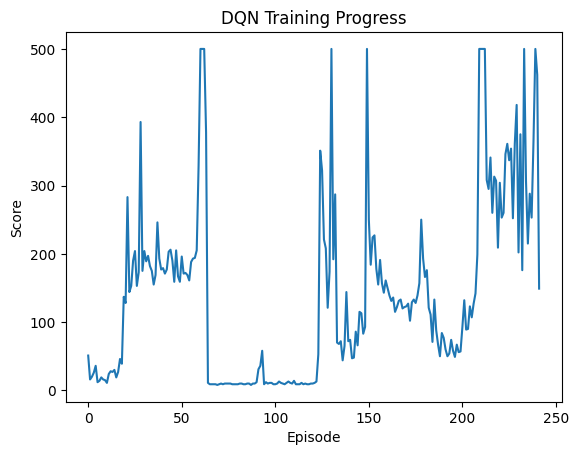

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x))  # Outputs Q-values for each action

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.1,
                 epsilon_decay=0.995, lr=0.001, batch_size=64,
                 memory_size=10000, target_update_freq=10):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Main Q-Network and Target Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = deque(maxlen=memory_size)
        self.learn_step_counter = 0

    def select_action(self, state, greedy=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if greedy or random.random() > self.epsilon:
            with torch.no_grad():
                return torch.argmax(self.q_network(state)).item()
        else:
            return random.randrange(self.action_dim)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q-values
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

        # Target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Loss and backpropagation
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def train_dqn(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)

    scores = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            agent.learn()

            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 195.0:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train_dqn(episodes=1000)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()


Episode 10, Average Score: 9.5
Episode 20, Average Score: 9.5
Episode 30, Average Score: 9.7
Episode 40, Average Score: 13.9
Episode 50, Average Score: 88.9
Episode 60, Average Score: 275.1
Episode 70, Average Score: 412.1
Episode 80, Average Score: 228.6
Episode 90, Average Score: 109.8
Episode 100, Average Score: 66.9
Episode 110, Average Score: 128.0
Episode 120, Average Score: 290.3
Episode 130, Average Score: 331.9
Solved at Episode 131


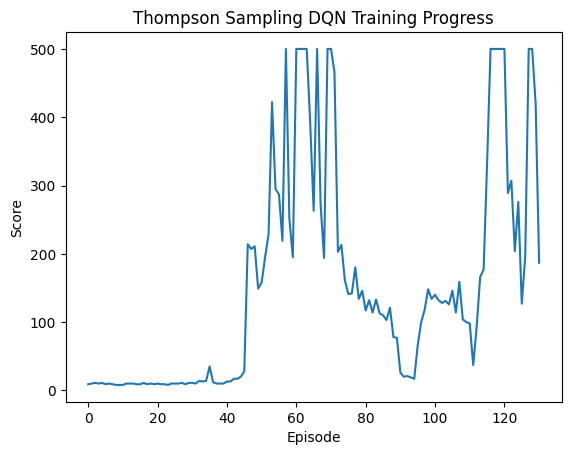

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action

class ThompsonDQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 gamma=0.99, lr=0.001, batch_size=64,
                 memory_size=10000, target_update_freq=10,
                 initial_alpha=1.0, initial_beta=1.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Main Q-Network and Target Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = deque(maxlen=memory_size)
        self.learn_step_counter = 0

        # Thompson Sampling parameters for each action
        self.alpha = np.ones(action_dim) * initial_alpha
        self.beta = np.ones(action_dim) * initial_beta

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Sample action probabilities using Beta distributions
        sampled_probs = np.array([np.random.beta(self.alpha[a], self.beta[a]) for a in range(self.action_dim)])

        # Select action with the highest sampled value
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]
            weighted_q_values = q_values * sampled_probs
            return np.argmax(weighted_q_values)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        # Update Thompson Sampling parameters
        if reward > 0:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q-values
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

        # Target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Loss and backpropagation
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

def train_thompson_dqn(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonDQNAgent(state_dim, action_dim)

    scores = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            agent.learn()

            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 195.0:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train_thompson_dqn(episodes=1000)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('Thompson Sampling DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()


Episode 10, Average Score: 9.3
Episode 20, Average Score: 9.7
Episode 30, Average Score: 10.2
Episode 40, Average Score: 9.0
Episode 50, Average Score: 9.9
Episode 60, Average Score: 10.3
Episode 70, Average Score: 10.2
Episode 80, Average Score: 9.9
Episode 90, Average Score: 10.4
Episode 100, Average Score: 13.6
Episode 110, Average Score: 29.2
Episode 120, Average Score: 10.2
Episode 130, Average Score: 10.2
Episode 140, Average Score: 12.8
Episode 150, Average Score: 12.4
Episode 160, Average Score: 11.3
Episode 170, Average Score: 14.3
Episode 180, Average Score: 17.6
Episode 190, Average Score: 43.7
Episode 200, Average Score: 44.3
Episode 210, Average Score: 37.0
Episode 220, Average Score: 27.3
Episode 230, Average Score: 41.2
Episode 240, Average Score: 40.8
Episode 250, Average Score: 48.0
Episode 260, Average Score: 63.5
Episode 270, Average Score: 41.0
Episode 280, Average Score: 48.6
Episode 290, Average Score: 60.1
Episode 300, Average Score: 40.8
Episode 310, Average Sco

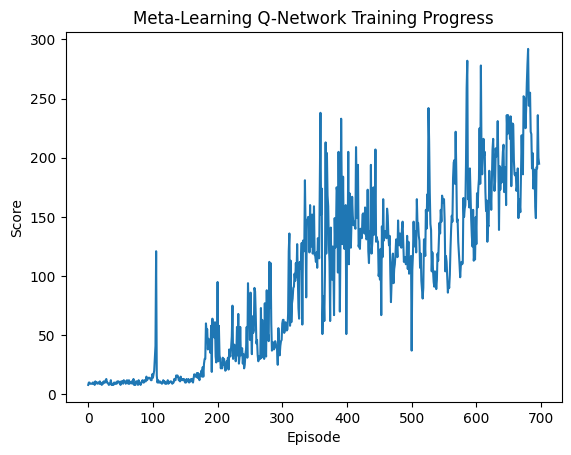

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque, OrderedDict
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action

class MetaQ:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 inner_lr=0.01, meta_lr=0.001, gamma=0.99,
                 memory_size=10000, batch_size=64,
                 target_update_freq=10, num_tasks=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Meta Q-Network and Target Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        self.gamma = gamma
        self.inner_lr = inner_lr
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.memory = deque(maxlen=memory_size)
        self.num_tasks = num_tasks
        self.learn_step_counter = 0

    def select_action(self, state, epsilon=0.1):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if random.random() > epsilon:
            with torch.no_grad():
                return torch.argmax(self.q_network(state)).item()
        else:
            return random.randrange(self.q_network.fc3.out_features)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def prepare_batch(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        return states, actions, rewards, next_states, dones

    def inner_loop_update(self, task_batch):
        # Perform task-specific updates
        states, actions, rewards, next_states, dones = self.prepare_batch(task_batch)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Update parameters using a temporary optimizer
        grads = torch.autograd.grad(loss, self.q_network.parameters())
        updated_params = OrderedDict()
        for (name, param), grad in zip(self.q_network.named_parameters(), grads):
            updated_params[name] = param - self.inner_lr * grad

        return updated_params

    def meta_update(self):
        if len(self.memory) < self.batch_size * 2 * self.num_tasks:
            return

        meta_loss = 0
        self.meta_optimizer.zero_grad()

        for _ in range(self.num_tasks):
            # Sample task-specific batches
            task_start = random.randint(0, len(self.memory) - self.batch_size * 2)
            task_batch = list(self.memory)[task_start:task_start + self.batch_size]
            eval_batch = list(self.memory)[task_start + self.batch_size:task_start + self.batch_size * 2]

            # Inner loop: Perform task-specific updates
            updated_params = self.inner_loop_update(task_batch)

            # Temporarily apply updated parameters
            original_params = OrderedDict((name, param.clone()) for name, param in self.q_network.named_parameters())
            for name, param in self.q_network.named_parameters():
                param.data = updated_params[name].data

            # Evaluate on evaluation batch
            states, actions, rewards, next_states, dones = self.prepare_batch(eval_batch)
            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

            # Meta loss
            task_meta_loss = F.mse_loss(q_values, target_q_values)
            meta_loss += task_meta_loss

            # Revert to original parameters
            for name, param in self.q_network.named_parameters():
                param.data = original_params[name].data

        # Outer loop: Meta optimization
        meta_loss = meta_loss / self.num_tasks
        meta_loss.backward()
        self.meta_optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        #print(f"Meta Loss: {meta_loss.item()}")

def train_meta_q(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = MetaQ(state_dim, action_dim)

    scores = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

        # Meta-update after each episode
        agent.meta_update()

        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 195.0:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train_meta_q(episodes=1000)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('Meta-Learning Q-Network Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()


Episode 10, Average Score: 9.6
Episode 20, Average Score: 9.1
Episode 30, Average Score: 9.2
Episode 40, Average Score: 9.5
Episode 50, Average Score: 9.2
Episode 60, Average Score: 9.5
Episode 70, Average Score: 9.3
Episode 80, Average Score: 8.9
Episode 90, Average Score: 9.4
Episode 100, Average Score: 10.1
Episode 110, Average Score: 11.7
Episode 120, Average Score: 22.0
Episode 130, Average Score: 22.2
Episode 140, Average Score: 9.5
Episode 150, Average Score: 28.3
Episode 160, Average Score: 27.9
Episode 170, Average Score: 17.0
Episode 180, Average Score: 15.9
Episode 190, Average Score: 29.0
Episode 200, Average Score: 38.4
Episode 210, Average Score: 54.6
Episode 220, Average Score: 43.4
Episode 230, Average Score: 21.7
Episode 240, Average Score: 23.1
Episode 250, Average Score: 36.9
Episode 260, Average Score: 47.0
Episode 270, Average Score: 54.9
Episode 280, Average Score: 54.3
Episode 290, Average Score: 43.6
Episode 300, Average Score: 63.6
Episode 310, Average Score: 7

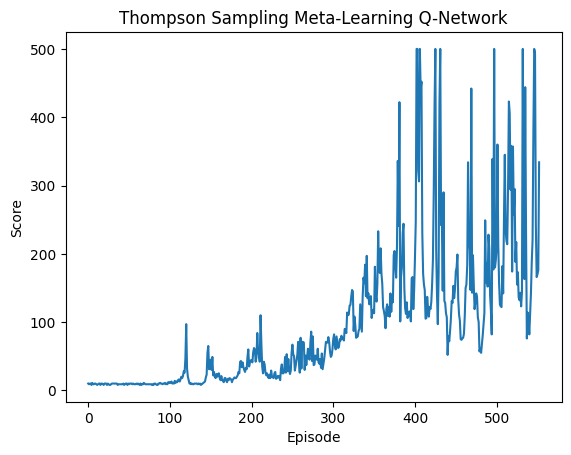

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque, OrderedDict
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action

class ThompsonMetaQ:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 inner_lr=0.01, meta_lr=0.001, gamma=0.99,
                 memory_size=10000, batch_size=64,
                 target_update_freq=10, num_tasks=5,
                 initial_alpha=1.0, initial_beta=1.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Meta Q-Network and Target Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        self.gamma = gamma
        self.inner_lr = inner_lr
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.memory = deque(maxlen=memory_size)
        self.num_tasks = num_tasks
        self.learn_step_counter = 0

        # Initialize Thompson Sampling parameters for each action
        self.alpha = np.ones(action_dim) * initial_alpha
        self.beta = np.ones(action_dim) * initial_beta

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Get Q-values
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]

        # Sample probabilities using Thompson Sampling
        sampled_probs = np.array([np.random.beta(self.alpha[a], self.beta[a]) for a in range(len(q_values))])

        # Select action based on weighted Q-values
        weighted_q_values = q_values * sampled_probs
        return np.argmax(weighted_q_values)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        # Update Thompson Sampling parameters
        if reward > 0:
            self.alpha[action] += 1  # Rewarded actions increase alpha
        else:
            self.beta[action] += 1  # Unsuccessful actions increase beta

    def prepare_batch(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        return states, actions, rewards, next_states, dones

    def inner_loop_update(self, task_batch):
        # Perform task-specific updates
        states, actions, rewards, next_states, dones = self.prepare_batch(task_batch)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Update parameters using a temporary optimizer
        grads = torch.autograd.grad(loss, self.q_network.parameters())
        updated_params = OrderedDict()
        for (name, param), grad in zip(self.q_network.named_parameters(), grads):
            updated_params[name] = param - self.inner_lr * grad

        return updated_params

    def meta_update(self):
        if len(self.memory) < self.batch_size * 2 * self.num_tasks:
            return

        meta_loss = 0
        self.meta_optimizer.zero_grad()

        for _ in range(self.num_tasks):
            # Sample task-specific batches
            task_start = random.randint(0, len(self.memory) - self.batch_size * 2)
            task_batch = list(self.memory)[task_start:task_start + self.batch_size]
            eval_batch = list(self.memory)[task_start + self.batch_size:task_start + self.batch_size * 2]

            # Inner loop: Perform task-specific updates
            updated_params = self.inner_loop_update(task_batch)

            # Temporarily apply updated parameters
            original_params = OrderedDict((name, param.clone()) for name, param in self.q_network.named_parameters())
            for name, param in self.q_network.named_parameters():
                param.data = updated_params[name].data

            # Evaluate on evaluation batch
            states, actions, rewards, next_states, dones = self.prepare_batch(eval_batch)
            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

            # Meta loss
            task_meta_loss = F.mse_loss(q_values, target_q_values)
            meta_loss += task_meta_loss

            # Revert to original parameters
            for name, param in self.q_network.named_parameters():
                param.data = original_params[name].data

        # Outer loop: Meta optimization
        meta_loss = meta_loss / self.num_tasks
        meta_loss.backward()
        self.meta_optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        #print(f"Meta Loss: {meta_loss.item()}")

def train_thompson_meta_q(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQ(state_dim, action_dim)

    scores = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

        # Meta-update after each episode
        agent.meta_update()

        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 195.0:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train_thompson_meta_q(episodes=1000)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('Thompson Sampling Meta-Learning Q-Network')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()
